# Hyperparameter Tuning System

Runs a multiprocessed hyperparameter study to identify optimal agent parameters

## Imports

In [1]:
import serial
import time
import random
import multiprocessing as mp
import visualizations
import copy

import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tqdm
from tqdm import tqdm

# Module imports
import rl_agent
from rl_agent import SoftmaxAgent

import solar_env
from solar_env import SolarEnv

import experiment_functions as ef

In [2]:
# Declare random seed
RANDOM_SEED = 1

## Functions

In [3]:
# DEPRECATED
# Runs a multiprocessed hyperparameter study
def run_hyperparam_study(environment:SolarEnv, steps, seed, 
                         temperature_values=[1*10**-x for x in range(0,5)], 
                         actor_step_size_values=[1*10**-x for x in range(0,5)], 
                         critic_step_size_values=[1*10**-x for x in range(0,5)], 
                         avg_reward_step_size_values=[1*10**-x for x in range(0,5)]):
    """
    Conduct a hyperparameter study
    
    Args:
        environment (SolarEnv): the environment to use for the study
        steps (int): the number of steps to run each set of hyperparameters for in an experiment
        seed (int): the random seed number to use for agent policy
    Kwargs:
        temperature_values (list): A list of values to study for temperature
        actor_step_size_values: A list of values to study for actor step size
        critic_step_size_values: A list of values to study for critic step size
        avg_reward_step_size_values: A list of values to study for avg reward step size
    Returns:
        DataFrame: A dataframe of hyperparameters and the reward they achieved in an experiment
    """
    
    # Create a dict list to hold all unique combinations of hyperparameters
    combinations_dict_list = []
    # Sweep temperature
    for temperature in temperature_values:
        # Sweep actor step size
        for actor_step_size in actor_step_size_values:
            # Sweep critic step size
            for critic_step_size in critic_step_size_values:
                # Sweep avg reward step size
                for avg_reward_step_size in avg_reward_step_size_values:
                    combinations_dict_list.append(
                        {'temperature': temperature,
                         'actor_step_size': actor_step_size,
                         'critic_step_size': critic_step_size,
                         'avg_reward_step_size': avg_reward_step_size
                        }
                    )
    # Create another dict list to hold results
    results_dict_list = []
    for combination in tqdm(combinations_dict_list):
        total_reward, _ = ef.run_agent_experiment(copy.copy(environment), steps, seed, **combination, hide_progress_bar=True)
        combination['total_reward'] = total_reward
        results_dict_list.append(combination)
    # Return a DataFrame of all the results
    return pd.DataFrame(results_dict_list)

In [4]:
def create_env_from_data_path(path, env_roll_frequency):
    # Set environment path
    experiment_data_path = path
    # Load in and format data, convert to array for environment
    data_df = solar_env.load_and_format_solar_df(experiment_data_path)
    env_reward_array = solar_env.convert_solar_df_to_value_array(data_df, 5)
    # env_reward_array = env_reward_array[10:,10:]
    return SolarEnv(env_reward_array, roll_frequency=env_roll_frequency)

In [5]:
# Runs a multiprocessed hyperparameter study
def run_hyperparam_study_mp(env_data_path, env_roll_frequency, 
                            steps, seed, cores,
                            temperature_values=[1*10**-x for x in range(0,5)],
                            actor_step_size_values=[1*10**-x for x in range(0,5)],
                            critic_step_size_values=[1*10**-x for x in range(0,5)],
                            avg_reward_step_size_values=[1*10**-x for x in range(0,5)],
                            batch_size=2000
                           ):
    """
    Conduct a hyperparameter study
    
    Args:
        env_data_path (str): path to env data
        env_roll_frequency (int): number of steps to shift env reward array at
        steps (int): the number of steps to run each set of hyperparameters for in an experiment
        seed (int): the random seed number to use for agent policy
        cores (int): number of cores to use for multiprocessing
    Kwargs:
        temperature_values (list): A list of values to study for temperature
        actor_step_size_values: A list of values to study for actor step size
        critic_step_size_values: A list of values to study for critic step size
        avg_reward_step_size_values: A list of values to study for avg reward step size
    Returns:
        DataFrame: A dataframe of hyperparameters and the reward they achieved in an experiment
    """
    
    # Create a dict list to hold all unique combinations of hyperparameters
    combinations_dict_list = []
    # Sweep temperature
    for temperature in temperature_values:
        # Sweep actor step size
        for actor_step_size in actor_step_size_values:
            # Sweep critic step size
            for critic_step_size in critic_step_size_values:
                # Sweep avg reward step size
                for avg_reward_step_size in avg_reward_step_size_values:
                    combinations_dict_list.append(
                        {'temperature': temperature,
                         'actor_step_size': actor_step_size,
                         'critic_step_size': critic_step_size,
                         'avg_reward_step_size': avg_reward_step_size
                        }
                    )
    # Create another dict list to hold results
    results_dict_list = []
    # Create dict to hold final results
    final_dict_list = []
    
    # Create batches
    num_batches = len(combinations_dict_list)//batch_size
    for i in tqdm(range(0, num_batches)):    
        # Determine indices
        min_index = batch_size * i
        max_index = batch_size * (i + 1)
        if max_index == num_batches:
            max_index = len(combinations_dict_list) - 1
        
        # Start pool for batch
        pool = mp.Pool(cores)
        temp_env = create_env_from_data_path(env_data_path, env_roll_frequency=env_roll_frequency)
        
        for combination in combinations_dict_list[min_index:max_index]:
            ## Resume here with multiprocessed training adaptation
            combination['total_reward'] = pool.apply_async(ef.run_agent_experiment, 
                                                           (copy.copy(temp_env), steps, seed, 
                                                            combination['actor_step_size'], 
                                                            combination['critic_step_size'],
                                                            combination['avg_reward_step_size'],
                                                            combination['temperature'],
                                                            10,
                                                            None, 
                                                            True)
                                                          )
            results_dict_list.append(combination)
            # total_reward, _ = ef.run_agent_experiment(environment, steps, seed, **combination, hide_progress_bar=True)
            # combination['total_reward'] = total_reward
        pool.close()
        pool.join()

        # Retrieve results
        final_dict_list = []
        for combination in results_dict_list:
            temp_dict = {}
            for key in combination.keys():
                if key != 'total_reward':
                    temp_dict[key] = combination[key]
                else:
                    temp_dict[key] = combination[key].get()
            final_dict_list.append(temp_dict)
            
    # Return a DataFrame of all the results
    return pd.DataFrame(final_dict_list)

## Run Study

### Env set up for experiment

In [12]:
# Set environment path
experiment_data_path = 'simulation_data/data/initial_environments/room_light_scan_3_23_22.csv'
# Set environment settings
env_roll_frequency = 10000

### Set parameters to sweep

In [ ]:
# Set hyperparam study values
temperature_values = [1*10**-x for x in range(0,5)]
temperature_values = list(np.append(np.array(temperature_values), np.array(temperature_values)*0.5))

actor_step_size_values = [1*10**-x for x in range(0,5)]
actor_step_size_values = list(np.append(np.array(actor_step_size_values), np.array(actor_step_size_values)*0.5))

critic_step_size_values = [1*10**-x for x in range(0,5)]
critic_step_size_values = list(np.append(np.array(critic_step_size_values), np.array(critic_step_size_values)*0.5))

avg_reward_step_size_values = [1*10**-x for x in range(0,5)]
avg_reward_step_size_values = list(np.append(np.array(avg_reward_step_size_values), np.array(avg_reward_step_size_values)*0.5))

In [ ]:
# Set number of steps in simulation for hyperparam study
num_sim_steps = 10000

In [ ]:
if __name__ == '__main__':
    study_df_parallel = run_hyperparam_study_mp(env_data_path=experiment_data_path, env_roll_frequency=env_roll_frequency,
                                                steps=num_sim_steps, seed=RANDOM_SEED, cores=mp.cpu_count(),
                                                temperature_values=temperature_values,
                                                actor_step_size_values=actor_step_size_values,
                                                critic_step_size_values=critic_step_size_values,
                                                avg_reward_step_size_values=avg_reward_step_size_values
                                               )

In [ ]:
study_df_parallel.sort_values(by='total_reward', ascending=False)

In [ ]:
px.scatter(study_df_parallel, x=[x for x in study_df_parallel.columns if x != 'total_reward'], y='total_reward', log_x=True)

#### Assess Agent Values

In [8]:
agent_combo = {
    'temperature': 0.0001,
    'actor_step_size': 0.1,
    'critic_step_size': 0.1,
    'avg_reward_step_size': 0.00001
}

In [ ]:
agent_combo = study_df_parallel.sort_values(by='total_reward', ascending=False).reset_index(drop=True).iloc[0].to_dict()

In [ ]:
agent_combo.pop('total_reward')

In [7]:
agent_combo

NameError: name 'agent_combo' is not defined

In [13]:
temp_env = create_env_from_data_path(experiment_data_path, env_roll_frequency=env_roll_frequency)
total_reward, tracking_df = ef.run_agent_experiment(temp_env, steps=100000, seed=RANDOM_SEED,
                        **agent_combo,
                        hide_progress_bar=False, logging_interval=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10147.20it/s]


In [14]:
total_reward

6018.783083998883

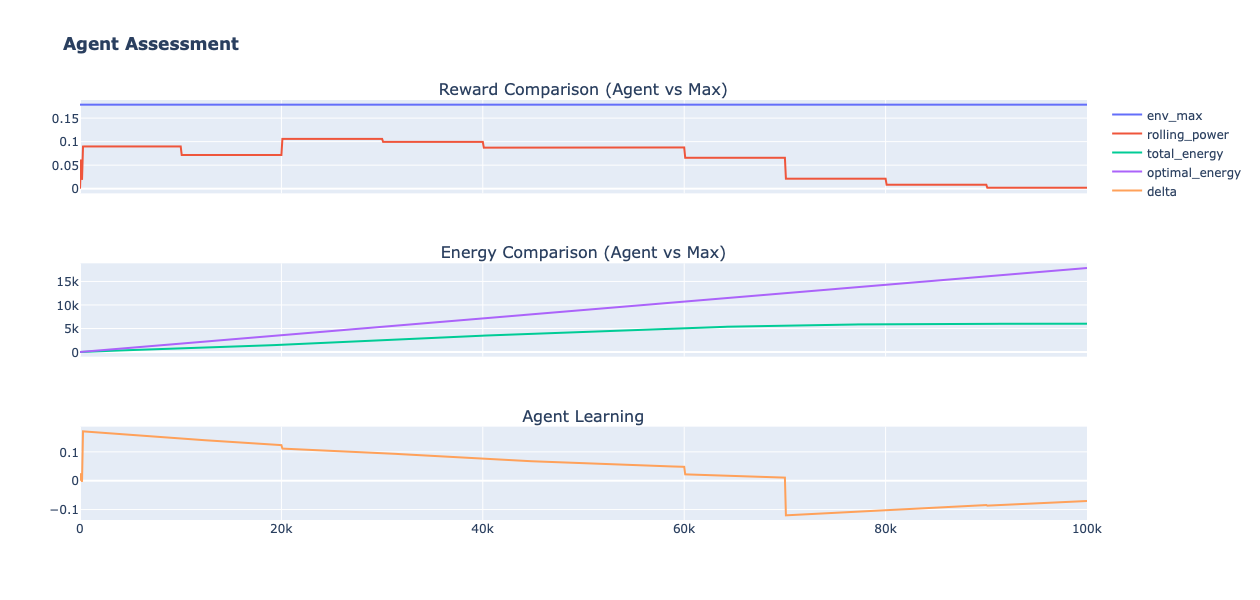

In [15]:
visualizations.plot_rolling_power(tracking_df, temp_env, height=600, width=800)